<a href="https://colab.research.google.com/github/sraminics/CMPE255Project/blob/master/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reading and Labeling the Data

In [0]:
import pandas as pd
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if not(os.path.exists('/content/train')):
    print('Unzipping train.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/train.zip'
    print('Unzipping test.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/test.zip'
    print('finished')
else:
    print('Already loaded') 

Already loaded


In [0]:
labels_raw = pd.read_csv("/content/drive/My Drive/CMPE297/dog-breed-identification/labels.csv")
labels_raw['id'] = labels_raw['id']+'.jpg'
labels_raw.head()




,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
labels = labels_raw


imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )


train_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)


val_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)


# test_datagen=ImageDataGenerator(rescale=1./255.)
# test_generator=test_datagen.flow_from_dataframe(
# dataframe=test_labels,
# directory="content/test/",
# x_col="id",
# y_col=None,
# batch_size=32,
# seed=42,
# shuffle=False,
# class_mode=None,
# target_size=(32,32))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [0]:
from keras.applications import ResNet50V2

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.trainable=False


Using TensorFlow backend.


In [0]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

model = models.Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(256, activation='relu')) Removing to increase Accuracy
model.add(layers.Dense(120, activation='softmax'))

model.compile(
    optimizer='adam', 
    loss=losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=val_generator,
      validation_steps=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 5.1673 - acc: 0.0312 - val_loss: 5.5077 - val_acc: 0.0563
Epoch 2/10
10/10 [==============================] - 6s 568ms/step - loss: 4.9249 - acc: 0.0344 - val_loss: 4.6993 - val_acc: 0.1125
Epoch 3/10
10/10 [==============================] - 6s 641ms/step - loss: 4.2992 - acc: 0.1125 - val_loss: 3.8016 - val_acc: 0.1906
Epoch 4/10
10/10 [==============================] - 7s 674ms/step - loss: 3.8728 - acc: 0.1531 - val_loss: 3.3169 - val_acc: 0.2344
Epoch 5/10
10/10 [==============================] - 7s 659ms/step - loss: 3.5763 - acc: 0.1969 - val_loss: 2.8562 - val_acc: 0.2875
Epoch 6/10
10/10 [==============================] - 7s 651ms/step - loss: 3.4265 - acc: 0.2375 - val_loss: 2.8403 - val_acc: 0.2938
Epoch 7/10
10/10 [==============================] - 8s 819ms/step - loss: 3.1684 - acc: 0.2750 - val_loss: 2.6244 

In [0]:
model.save('dog_breads.h5')

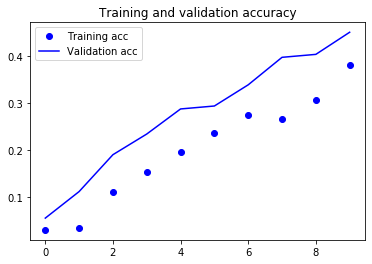

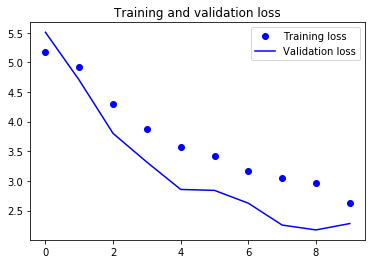

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Improving Accuracy By using Top 15 Dog Breeds(where there are more than 100)

In [0]:
labels_raw['breed'].value_counts()[:16]

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
airedale                107
tibetan_terrier         107
leonberg                106
cairn                   106
japanese_spaniel        105
beagle                  105
Name: breed, dtype: int64

In [0]:
array = ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernes_mountain_dog', 'shih-tzu', 'pomeranian', 'great_pyrenees', 'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg', 'cairn', 'japanese_spaniel', 'beagle']
labels_10_raw = labels_raw.loc[labels_raw['breed'].isin(array)]

In [0]:
labels_10_raw.head()

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9.jpg,basenji
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec.jpg,maltese_dog
29,00bee065dcec471f26394855c5c2f3de.jpg,cairn
48,013f8fdf6d638c7bb042f5f17e8a9fdc.jpg,tibetan_terrier


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
labels = labels_10_raw


imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )


train_10_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)


val_10_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)

Found 1331 validated image filenames belonging to 15 classes.
Found 332 validated image filenames belonging to 15 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

model = models.Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(256, activation='relu')) Removing to increase Accuracy
model.add(layers.Dense(15, activation='softmax'))

model.compile(
    optimizer='adam', 
    loss=losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [0]:
history10 = model.fit_generator(
      train_10_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=val_10_generator,
      validation_steps=10,
      shuffle=True)

Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 2.5857 - acc: 0.1594 - val_loss: 2.0072 - val_acc: 0.3875
Epoch 2/10
10/10 [==============================] - 8s 809ms/step - loss: 1.9864 - acc: 0.3688 - val_loss: 1.0386 - val_acc: 0.6700
Epoch 3/10
10/10 [==============================] - 6s 606ms/step - loss: 1.4664 - acc: 0.5906 - val_loss: 0.8099 - val_acc: 0.7533
Epoch 4/10
10/10 [==============================] - 5s 485ms/step - loss: 1.2529 - acc: 0.6500 - val_loss: 0.4999 - val_acc: 0.8567
Epoch 5/10
10/10 [==============================] - 8s 835ms/step - loss: 0.9757 - acc: 0.7250 - val_loss: 0.4671 - val_acc: 0.8367
Epoch 6/10
10/10 [==============================] - 6s 614ms/step - loss: 0.8742 - acc: 0.7656 - val_loss: 0.4256 - val_acc: 0.8800
Epoch 7/10
10/10 [==============================] - 6s 620ms/step - loss: 0.8006 - acc: 0.7875 - val_loss: 0.4335 - val_acc: 0.8400
Epoch 8/10
10/10 [==============================] - 6s 615ms/step - loss: 0.81

In [0]:
model.save('dog_breads_top_10.h5')

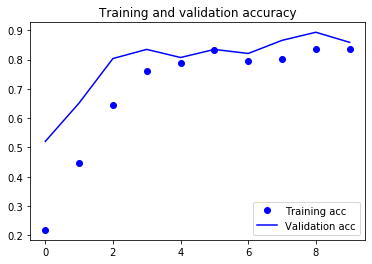

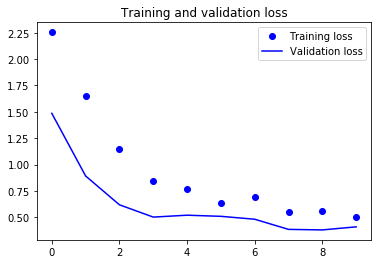

In [0]:
import matplotlib.pyplot as plt
acc = history10.history['acc']
val_acc = history10.history['val_acc']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Visualization

In [0]:
from keras.models import load_model

model = load_model('dog_breads_top_10.h5')
model.summary()  # As a reminder.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 23,765,240
Non-trainable params: 45,440
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
img_path = '/Users/fchollet/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg'